# Diff in Diff: Carbon Pricing and innovation in China

This document is the one I actually produced when I dived into the data. 

**Overview:**
Diff-in-Diff is a powerful tool and is commonly used to measure the effect of a reform/policy. Cui et al. (2018) study the effect of ETS (Emission Trading Scheme) on low-carbon innovation. The study will actually go further than a Diff-in-Diff and use a triple difference (an additional layer reinforcing the identification strategy).

**Setup:**
- ETS: "*Emissions trading is a market-based approach to controlling pollution by providing economic incentives for reducing the emissions of pollutants.*" Wikipedia
- ETS in this case: China implemented an ETS cap-and-trade, meaning that the government defines a total cap on $CO^2$ emission for a region. Each company receives an initial number of permits (corresponding to a quantity of emissions). If a company wants to pollute more they have to buy the permit from another.
- Spatial coverage: The 2011 pilot model in China was launched in 4 municipalities (Beijing, Chongqing, Shanghai, and Tianjin), 2 provinces (Guangdong and Hubei), and the special economic zone of Shenzhen City.
![map with ETS](./figure/Chinese-ETS.png "Chinese pilot ETS")

- This program concerns only some regions and some sectors. Hence we will be able to exploit the pre-post reform difference (first difference), but also the region differences (second difference), and additional the sector difference (third difference).

## 1. Variables selection
- **outcome:** Number of low carbon patents
- **explanatory variable:** region (pilot region or not)
- **heterogeneity:** sector (subject to ETS or not), period (pre/post).

## 2. Sample selection
We have a panel dataset company-year from 2003 to 2015 with 1956 companies.

List of main variables:
- *id:* id of the firm
- *year*
- *region:* 1 if region subjects to ETS, 0 otherwise
- *Ind:* 1 if industry subjects to ETS, 0 otherwise
- *post:* 1 for the post period, 0 otherwise
- *logenvrAEW:* log(number of low-carbon patents)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import numpy as np
import linearmodels as lm
from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [2]:
df = pd.read_stata("./cui_et_al.dta")
df_s = df[['id', 'year', 'region', 'Ind', 'post', 'logenvrAEW']]
df_s.head()

,id,year,region,Ind,post,logenvrAEW
0,1854.0,2003.0,1.0,0.0,0.0,0.0
1,1854.0,2004.0,1.0,0.0,0.0,0.0
2,1854.0,2005.0,1.0,0.0,0.0,0.0
3,1854.0,2006.0,1.0,0.0,0.0,0.0
4,1854.0,2007.0,1.0,0.0,0.0,0.0


In [3]:
df_s.describe()

,id,year,region,Ind,post,logenvrAEW
count,18937.000000,18824.000000,18937.000000,18937.000000,18937.000000,18937.000000
mean,991.293945,2009.903262,0.274436,0.342398,0.481280,0.290259
std,582.523499,3.543904,0.446194,0.474493,0.499659,0.712681
min,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000
25%,445.000000,2007.000000,0.000000,0.000000,0.000000,0.000000
50%,1081.000000,2010.000000,0.000000,0.000000,0.000000,0.000000
75%,1445.000000,2013.000000,1.000000,1.000000,1.000000,0.000000
max,1956.000000,2015.000000,1.000000,1.000000,1.000000,5.894403


**Note:** Some observations do not have the year. Let's drop those.

In [4]:
df_s = df_s[df_s['year'].notna()]
df_s.describe()

,id,year,region,Ind,post,logenvrAEW
count,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000
mean,989.896423,2009.903262,0.274012,0.343073,0.478166,0.292001
std,582.949158,3.543904,0.446070,0.474748,0.499548,0.714450
min,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000
25%,442.000000,2007.000000,0.000000,0.000000,0.000000,0.000000
50%,1081.000000,2010.000000,0.000000,0.000000,0.000000,0.000000
75%,1443.000000,2013.000000,1.000000,1.000000,1.000000,0.000000
max,1956.000000,2015.000000,1.000000,1.000000,1.000000,5.894403


## 3. Univariate analysis
### 3.1 Low carbon patents
- This variable is already log transformed. Hence, let's first generate the level variable and think if the log is adequate or not. 

In [5]:
#They used the log(X+1) transformation
df_s['envrAEW'] = np.exp(df_s['logenvrAEW'])-1
df_s.describe()

,id,year,region,Ind,post,logenvrAEW,envrAEW
count,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000
mean,989.896423,2009.903262,0.274012,0.343073,0.478166,0.292001,1.382278
std,582.949158,3.543904,0.446070,0.474748,0.499548,0.714450,7.916742
min,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,442.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1081.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1443.000000,2013.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1956.000000,2015.000000,1.000000,1.000000,1.000000,5.894403,362.000061


Skewness envrAEW: 
17.26020701932449


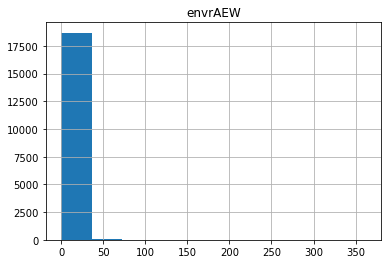

In [6]:
#histogram and skewness
df_s.hist(column='envrAEW')

print("Skewness envrAEW: ")
print(skew(df_s['envrAEW'], nan_policy='omit'))

In [7]:
#The data are so asymmetric that a table would fit better.
df_s.groupby(['envrAEW']).size().reset_index(name='counts')

,envrAEW,counts
0,0.000000,15215
1,1.000000,1097
2,2.000000,706
3,3.000000,351
4,4.000000,271
...,...,...
100,194.000031,1
101,197.000015,1
102,198.000031,1
103,253.000061,1


array([[<AxesSubplot:title={'center':'envrAEW'}>]], dtype=object)

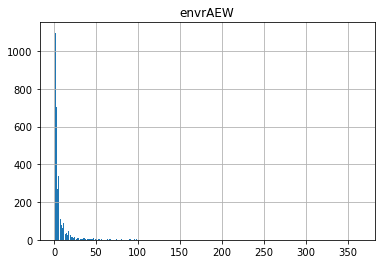

In [8]:
#104 unique values, still hard to read. So, let's play with the histogram. 
df_s[df_s['envrAEW'] > 0].hist(column='envrAEW', bins=range(1,365,1))

array([[<AxesSubplot:title={'center':'envrAEW'}>]], dtype=object)

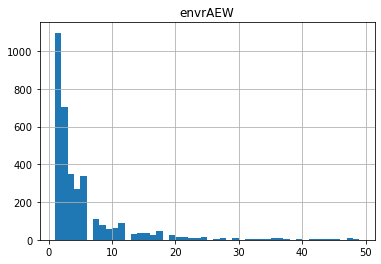

In [9]:
df_s[(df_s['envrAEW'] > 0) & (df_s['envrAEW'] < 50)].hist(column='envrAEW', bins=range(1,50,1))

**Note:** Clearly, the data are highly asymmetric with a Skewness of 17 (mean 2.38 and a median of 1). In this case we could use the log transformation (log(X+1) as in the paper. Or we could use a dummy taking the value 1 if at least one patent with low carbon was submitted. We have 80% (15215/18824=0.8) of zeros.

In [10]:
df_s['envrAEW_bin'] = (df_s['envrAEW']>0).astype('int')
df_s['envrAEW_bin'].describe()

count    18824.000000
mean         0.191723
std          0.393667
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: envrAEW_bin, dtype: float64

Skewness logenvrAEW: 
2.944784591106004


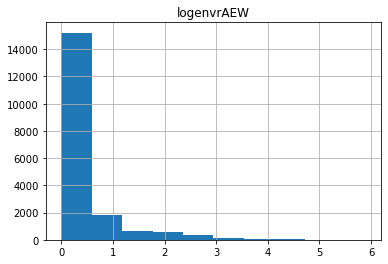

In [11]:
#histogram and skewness
df_s.hist(column='logenvrAEW')

print("Skewness logenvrAEW: ")
print(skew(df_s['logenvrAEW'], nan_policy='omit'))

**Note:** Better but still very high. Rule of thumb for skewness: if above three, it's too high to rely on the mean.

For the analysis, we will exploit the within-region, within-sector variation. Let's dive into the subgroups.

Skewness logenvrAEW: 
2.5224967741289865


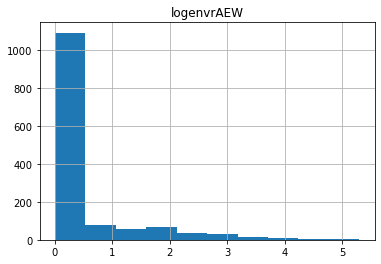

In [12]:
#histogram and skewness
df_s[(df_s['Ind'] == 1) & (df_s['region'] == 1)].hist(column='logenvrAEW')

print("Skewness logenvrAEW: ")
print(skew(df_s[(df_s['Ind'] == 1) & (df_s['region'] == 1)]['logenvrAEW'], nan_policy='omit'))

Skewness logenvrAEW: 
2.9748141771225836


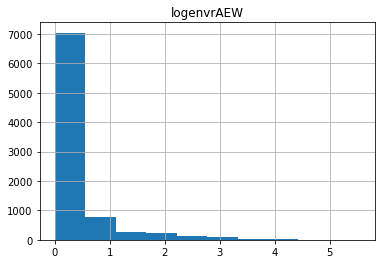

In [13]:
#histogram and skewness
df_s[(df_s['Ind'] == 0) & (df_s['region'] == 0)].hist(column='logenvrAEW')

print("Skewness logenvrAEW: ")
print(skew(df_s[(df_s['Ind'] == 0) & (df_s['region'] == 0)]['logenvrAEW'], nan_policy='omit'))

Skewness logenvrAEW: 
2.8168711227893333


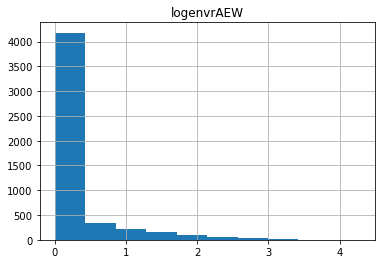

In [14]:
#histogram and skewness
df_s[(df_s['Ind'] == 1) & (df_s['region'] == 0)].hist(column='logenvrAEW')

print("Skewness logenvrAEW: ")
print(skew(df_s[(df_s['Ind'] == 1) & (df_s['region'] == 0)]['logenvrAEW'], nan_policy='omit'))

Skewness logenvrAEW: 
2.610751454641935


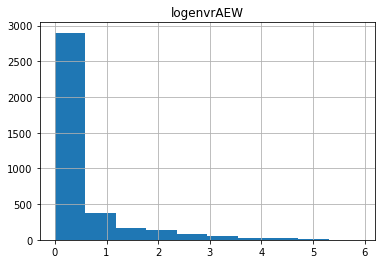

In [15]:
#histogram and skewness
df_s[(df_s['Ind'] == 0) & (df_s['region'] == 1)].hist(column='logenvrAEW')

print("Skewness logenvrAEW: ")
print(skew(df_s[(df_s['Ind'] == 0) & (df_s['region'] == 1)]['logenvrAEW'], nan_policy='omit'))

**Note:** This is bad in my opinion. The paper exploits highly asymmetric data and relies on the mean... The mean is just a bad measure. I will do some robustness tests where: 1. I use a dummy as the outcome, 2. I remove "extreme values".

## 4 Bivariate analysis
### 4.1 Figure 1 (DDD)
First we are going to replicate Figure 1 from the paper. 

In [12]:
df_mean = df_s.groupby(['year', 'region', 'Ind'])['envrAEW'].agg(['mean'])
df_mean.reset_index(inplace=True)
df_mean

,year,region,Ind,mean
0,2003.0,0.0,0.0,0.084699
1,2003.0,0.0,1.0,0.029963
2,2003.0,1.0,0.0,0.248322
3,2003.0,1.0,1.0,0.558824
4,2004.0,0.0,0.0,0.081841
5,2004.0,0.0,1.0,0.079861
6,2004.0,1.0,0.0,0.234940
7,2004.0,1.0,1.0,0.514286
8,2005.0,0.0,0.0,0.151961
9,2005.0,0.0,1.0,0.069767


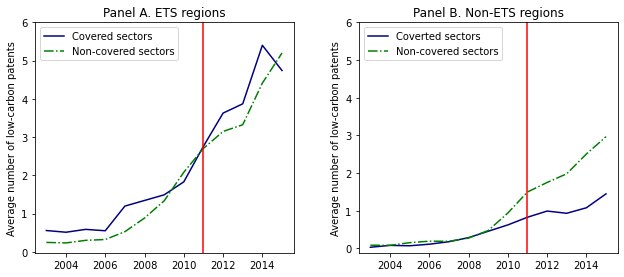

In [15]:
#Low-carbon innovation per firm by ETS regions and covered sectors
plt.axes([.05,.05,.6,.8])
#1st Value — Bottom Left Corner X Coordinate
#2nd Value — Bottom Left Corner Y Coordinate
#3rd Value — Width of the plot
#4th Value — Height of the plot
# Here is a full article explaining how to create such graphs:
# https://towardsdatascience.com/data-visualization-using-python-422d7ac4cb65

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['mean'],
         color = "navy",linestyle = '-', label = "Covered sectors")

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['mean'],
         color = "green", linestyle = '-.', label = "Non-covered sectors")
plt.title("Panel A. ETS regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(7))
plt.legend()




plt.axes([.8,.05,.6,.8])
plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['mean'],
         color = "navy",linestyle = '-', label = "Coverted sectors")

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['mean'],
         color = "green", linestyle = '-.', label = "Non-covered sectors")
plt.title("Panel B. Non-ETS regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(7))
plt.legend()
plt.show()

**Note:** This graph is not easy to interpret. Let's try to understand what it says. In a traditional DiD model, we would compare treated pre-post with control pre-post. Here we have two options for the control. Either the same region but a different sector (not ETS) or the same sector but a different region (not ETS). 
### 4.2 DiD (control different regions same sectors)

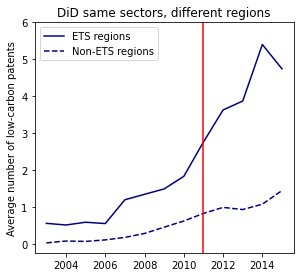

In [16]:
plt.axes([.05,.05,.6,.8])

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['mean'],
         color = "navy",linestyle = '-', label = "ETS regions")

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['mean'],
         color = "navy", linestyle = '--', label = "Non-ETS regions")
plt.title("DiD same sectors, different regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(7))
plt.legend()

plt.show()

### 4.3 Why the triple difference?

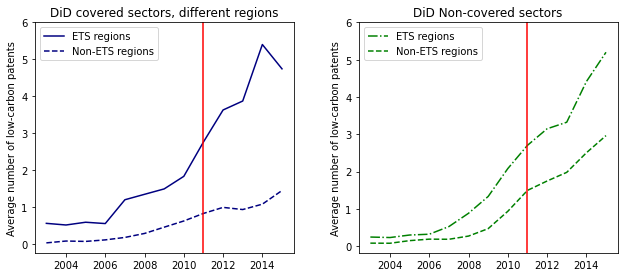

In [18]:
plt.axes([.05,.05,.6,.8])

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['mean'],
         color = "navy",linestyle = '-', label = "ETS regions")

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['mean'],
         color = "navy", linestyle = '--', label = "Non-ETS regions")
plt.title("DiD covered sectors, different regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(7))
plt.legend()


plt.axes([.8,.05,.6,.8])

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['mean'],
         color = "green",linestyle = '-.', label = "ETS regions")

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['mean'],
         color = "green", linestyle = '--', label = "Non-ETS regions")
plt.title("DiD Non-covered sectors")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(7))
plt.legend()
plt.show()

**Note:** So the graph on the left could be a simple Diff in Diff. But, what if the regions with ETS and without ETS evolved differently.

### 4.4 What about the probability of producing a low carbon patent?

In [24]:
df_mean = df_s.groupby(['year', 'region', 'Ind'])['envrAEW_bin'].agg(['mean'])
df_mean.reset_index(inplace=True)

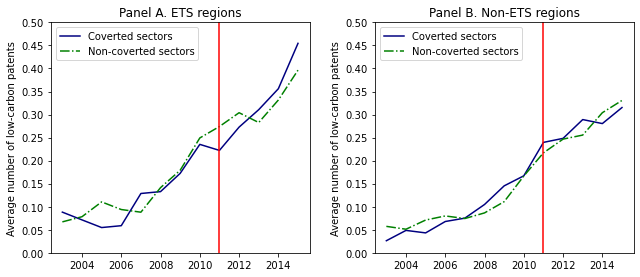

In [26]:
#Low-carbon innovation per firm by ETS regions and coverted sectors
plt.axes([.05,.05,.6,.8])

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['mean'],
         color = "navy",linestyle = '-', label = "Coverted sectors")

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['mean'],
         color = "green", linestyle = '-.', label = "Non-coverted sectors")
plt.title("Panel A. ETS regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(np.linspace(0,0.5,11))
plt.legend()

plt.axes([.8,.05,.6,.8])
plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['mean'],
         color = "navy",linestyle = '-', label = "Coverted sectors")

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['mean'],
         color = "green", linestyle = '-.', label = "Non-coverted sectors")
plt.title("Panel B. Non-ETS regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(np.linspace(0,0.5,11))
plt.legend()
plt.show()

**Note:** Just no difference in terms of probabilities (at least it seems so). So the effect could be driven by some companies inventing a ton. 

### 4.5 Removing "extreme values"

In [23]:
df_s['logenvrAEW'].describe()

count    18824.000000
mean         0.292001
std          0.714450
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.894403
Name: logenvrAEW, dtype: float64

In [19]:
df_cut = df_s[df_s['logenvrAEW']< 0.292001+3*0.714450 ]
df_cut.describe()

,id,year,region,Ind,post,logenvrAEW,envrAEW,envrAEW_bin
count,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000,18281.000000
mean,984.810120,2009.826487,0.267764,0.346097,0.467972,0.205693,0.491822,0.167715
std,583.832703,3.545574,0.442818,0.475749,0.498987,0.504424,1.444521,0.373623
min,1.000000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,435.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1075.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1437.000000,2013.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1956.000000,2015.000000,1.000000,1.000000,1.000000,2.397895,10.000001,1.000000


Skewness logenvrAEW: 
2.4998015521888903


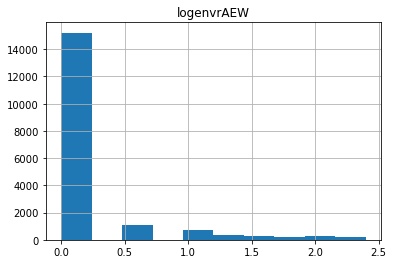

In [20]:
#histogram and skewness
df_cut.hist(column='logenvrAEW')

print("Skewness logenvrAEW: ")
print(skew(df_cut['logenvrAEW'], nan_policy='omit'))

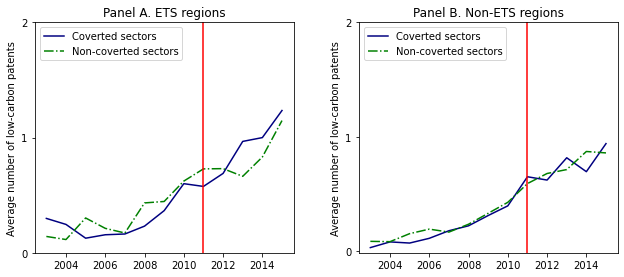

In [21]:
df_mean = df_cut.groupby(['year', 'region', 'Ind'])['envrAEW'].agg(['mean'])
df_mean.reset_index(inplace=True)
#Low-carbon innovation per firm by ETS regions and coverted sectors
plt.axes([.05,.05,.6,.8])

plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 1)]['mean'],
         color = "navy",linestyle = '-', label = "Coverted sectors")

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 1)]['mean'],
         color = "green", linestyle = '-.', label = "Non-coverted sectors")
plt.title("Panel A. ETS regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(3))
plt.legend()




plt.axes([.8,.05,.6,.8])
plt.plot(df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 1) & (df_mean['region'] == 0)]['mean'],
         color = "navy",linestyle = '-', label = "Coverted sectors")

plt.plot(df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['year'],
         df_mean[(df_mean['Ind'] == 0) & (df_mean['region'] == 0)]['mean'],
         color = "green", linestyle = '-.', label = "Non-coverted sectors")
plt.title("Panel B. Non-ETS regions")
plt.xlabel("")
plt.ylabel("Average number of low-carbon patents")
plt.axvline(x=2011, ymin=0, ymax=6, color='red')
plt.yticks(range(3))
plt.legend()
plt.show()

**Note:** The effect is also gone, by getting rid of the top 2.9% (1-18281/18824) observations.

## 5 Multivariate analysis
Let us now use a regression to replicate their results.
### 5.1 DDD 

In [27]:
df_did = df.dropna(subset=['year'])
df_did.describe()

,id,year,t_Revenue,t_Assets,t_CurrentLiability,t_ROA,t_EBIT,region,Ind,post,price,turnover,logNon_envrAEW,logNon_envrAE,logenvrAEW,logenvrAEWRD,logenvrAE,logenvrAERD,envrAEW_ratio
count,18824.000000,18824.000000,18806.000000,18813.000000,18812.000000,15737.000000,17106.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,18824.000000,12392.000000,18824.000000,12392.000000,18824.000000
mean,989.896423,2009.903262,20.870200,21.369430,20.271076,-3.178991,18.468386,0.274012,0.343073,0.478166,2.717414,0.001395,1.471617,1.485619,0.292001,-16.593191,0.208004,-16.697453,0.028197
std,582.949158,3.543904,1.486929,1.368776,1.530324,1.121383,1.461707,0.446070,0.474748,0.499548,10.531152,0.006458,1.659660,1.666690,0.714450,1.449885,0.611830,1.468604,0.090591
min,1.000000,2003.000000,11.599166,12.314250,14.525826,-11.323103,9.817387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.172535,0.000000,-22.172535,0.000000
25%,442.000000,2007.000000,19.870979,20.500013,19.213544,-3.725316,17.584694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.519878,0.000000,-17.619230,0.000000
50%,1081.000000,2010.000000,20.753453,21.267792,20.212852,-2.986127,18.336624,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,1.098612,0.000000,-16.657688,0.000000,-16.744883,0.000000
75%,1443.000000,2013.000000,21.721397,22.113351,21.176041,-2.417310,19.264624,1.000000,1.000000,1.000000,0.000000,0.000000,2.708050,2.708050,0.000000,-15.839451,0.000000,-15.930978,0.000000
max,1956.000000,2015.000000,28.688919,28.508727,27.193274,-0.386128,26.063501,1.000000,1.000000,1.000000,64.834442,0.056064,9.212638,9.231809,5.894403,-4.744932,5.537334,-4.744932,0.952381


In [28]:
#generate the interaction variables
df_did['post_region'] = df_did['post']*df_did['region']
df_did['post_Ind'] = df_did['post']*df_did['Ind']
df_did['post_region_Ind'] = df_did['post']*df_did['region']*df_did['Ind']

# Set the index for fixed effects
df_did.reset_index(inplace=True)
df_did = df_did.set_index(['id', 'year'])

C:\Users\qgallea\AppData\Local\Temp\ipykernel_13960\3277628671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_did['post_region'] = df_did['post']*df_did['region']
C:\Users\qgallea\AppData\Local\Temp\ipykernel_13960\3277628671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_did['post_Ind'] = df_did['post']*df_did['Ind']
C:\Users\qgallea\AppData\Local\Temp\ipykernel_13960\3277628671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [29]:
FE1 = PanelOLS(df_did.logenvrAEW, df_did[['post_Ind','post_region','post_region_Ind','t_Revenue','t_Assets',
                                          't_CurrentLiability','t_ROA','t_EBIT']],
              entity_effects = True,
              time_effects = True
              )

# Result
reg1 = FE1.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg1

C:\Users\qgallea\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,logenvrAEW,R-squared:,0.0285
Estimator:,PanelOLS,R-squared (Between):,-41.239
No. Observations:,15672,R-squared (Within):,0.1301
Date:,"Tue, Dec 06 2022",R-squared (Overall):,-18.739
Time:,22:14:19,Log-likelihood,-1.029e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,50.663
Entities:,1842,P-value,0.0000
Avg Obs:,8.5081,Distribution:,"F(8,13810)"
Min Obs:,1.0000,,
Max Obs:,13.000,F-statistic (robust):,14.658


**Note:** Effect statistcally significant and in the ballpark of the previous estimates.

### 5.2 DDD with binary outcome

In [30]:
df_did['envrAEW'] = np.exp(df_did['logenvrAEW'])-1
df_did['envrAEW_bin'] = (df_did['envrAEW']>0).astype('int')
df_did['envrAEW_bin'].describe()

count    18824.000000
mean         0.191723
std          0.393667
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: envrAEW_bin, dtype: float64

In [31]:
FE1 = PanelOLS(df_did.envrAEW_bin, df_did[['post_Ind','post_region','post_region_Ind','t_Revenue','t_Assets',
                                          't_CurrentLiability','t_ROA','t_EBIT']],
              entity_effects = True,
              time_effects = True
              )

# Result
reg1 = FE1.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg1

C:\Users\qgallea\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,envrAEW_bin,R-squared:,0.0208
Estimator:,PanelOLS,R-squared (Between):,-49.587
No. Observations:,15672,R-squared (Within):,0.1270
Date:,"Tue, Dec 06 2022",R-squared (Overall):,-20.114
Time:,22:15:00,Log-likelihood,-2516.1
Cov. Estimator:,Clustered,,
,,F-statistic:,36.664
Entities:,1842,P-value,0.0000
Avg Obs:,8.5081,Distribution:,"F(8,13810)"
Min Obs:,1.0000,,
Max Obs:,13.000,F-statistic (robust):,18.742


**Note:** Effect far from stat. sig. 

### 5.3 Excluding top values of logenvrAEW

In [32]:
df_did['logenvrAEW'].describe()

count    18824.000000
mean         0.292001
std          0.714450
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.894403
Name: logenvrAEW, dtype: float64

In [35]:
df_cut = df_did[df_did['logenvrAEW']< 0.292001+3*0.714450 ]

In [36]:
FE3 = PanelOLS(df_cut.logenvrAEW, df_cut[['post_Ind','post_region','post_region_Ind','t_Revenue','t_Assets',
                                          't_CurrentLiability','t_ROA','t_EBIT']],
              entity_effects = True,
              time_effects = True
              )

# Result
reg3 = FE3.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg3

C:\Users\qgallea\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,logenvrAEW,R-squared:,0.0196
Estimator:,PanelOLS,R-squared (Between):,-46.969
No. Observations:,15207,R-squared (Within):,0.1115
Date:,"Tue, Dec 06 2022",R-squared (Overall):,-20.582
Time:,22:16:23,Log-likelihood,-6579.3
Cov. Estimator:,Clustered,,
,,F-statistic:,33.339
Entities:,1842,P-value,0.0000
Avg Obs:,8.2557,Distribution:,"F(8,13345)"
Min Obs:,1.0000,,
Max Obs:,13.000,F-statistic (robust):,14.361


### 5.4 Only top values of logenvrAEW

In [37]:
df_cut2 = df_did[df_did['logenvrAEW']>= 0.292001+3*0.714450 ]

In [38]:
FE4 = PanelOLS(df_cut2.logenvrAEW, df_cut2[['post_Ind','post_region','post_region_Ind','t_Revenue','t_Assets',
                                          't_CurrentLiability','t_ROA','t_EBIT']],
              entity_effects = True,
              time_effects = True
              )

# Result
reg4 = FE4.fit(cov_type = 'clustered',
             cluster_entity=True,
             # cluster_time=True
              )

reg4

C:\Users\qgallea\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,logenvrAEW,R-squared:,0.0705
Estimator:,PanelOLS,R-squared (Between):,0.2722
No. Observations:,465,R-squared (Within):,-0.0634
Date:,"Tue, Dec 06 2022",R-squared (Overall):,0.3654
Time:,22:17:24,Log-likelihood,-151.80
Cov. Estimator:,Clustered,,
,,F-statistic:,2.4947
Entities:,182,P-value,0.0126
Avg Obs:,2.5549,Distribution:,"F(8,263)"
Min Obs:,1.0000,,
Max Obs:,11.000,F-statistic (robust):,1.1254


## 6. Conclusion
This is an interesting dataset and idea. However, several things are problematic:
1. The dependent variable is highly positively skewed and hence a linear model is not adequate.
2. The results seem to be driven only by extreme values. We could/should use quantile regression.
3. The counterfactual is peculiar. The effect is driven by the non-covered firms outside of the pilot increasing their patent submissions. Why?

Note that this was just a draft for a presentation, no paper has been published after (at least I didn't find one). It was cited 60 times though (even in Nature communications).